In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
import scipy.ndimage as ndimage

In [2]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import USCOUNTIES
import matplotlib.patheffects as pe

In [3]:
import cmocean
import xarray as xr
import numpy as np
import pathlib
import sys
import os
import pandas as pd

In [31]:
from dateparser import parse
from matplotlib import font_manager

### loads custom color map

In [5]:
from cpt_convert import loadCPT
cpt = loadCPT('/Users/nollb/weather/cpt/pwat2.cpt')
cpt_convert = LinearSegmentedColormap('cpt', cpt)

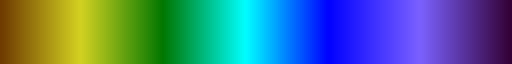

In [6]:
cpt_convert

### parses dates and run time

In [8]:
date = parse('today GMT')

date = date.strftime("%Y%m%d")

### defines fig path

In [9]:
fig_path = "../imagery/{}/pwat_pressure".format(date)

In [10]:
fig_path = pathlib.Path(fig_path)

In [11]:
if fig_path.exists() == False:
    fig_path.mkdir(parents = True)

### opens dset

In [12]:
ds = xr.open_dataset('../data/ecmwf.nc')

### data munging

In [16]:
tcwv = ds['tcwv']*0.0393701 # Converts water vapor to inches

In [17]:
tcwv = tcwv.sortby('valid_time')

In [18]:
mslp = ds['msl']

In [19]:
mslp = mslp / 100 # Converts air pressure to mean sea level

In [20]:
mslp = mslp.sortby('valid_time')

### applies filter to smooth air pressure contour lines

In [21]:
mslp = ndimage.gaussian_filter(mslp, sigma=0.75, order=0)

### sets time

In [22]:
conv = tcwv['valid_time'].dt.strftime('%Y-%m-%d %H')

In [23]:
conv = conv.values

In [24]:
valid_time = tcwv['valid_time'].dt.round('H')

/opt/anaconda3/envs/climate/lib/python3.12/site-packages/xarray/core/accessor_dt.py:163: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  field_values = method(freq=freq).values


In [25]:
utc = valid_time.to_index()

In [26]:
local = utc.tz_localize('GMT').tz_convert('America/New_York')

In [27]:
local_time = local.strftime("%Y-%m-%d")

In [28]:
formatted_dates = pd.to_datetime(local_time).strftime("%b. %d")

### plots

In [29]:
lats = ds.variables['latitude'][:]  
lons = ds.variables['longitude'][:]

### wapo styling

In [32]:
font_path = '../fonts/Franklin/FranklinITCStd-Black.otf'
font_properties = font_manager.FontProperties(fname=font_path)

font_path2 = '../fonts/Franklin/FranklinITCStd-Bold.otf'
font_properties2 = font_manager.FontProperties(fname=font_path2)

font_path3 = '../fonts/Franklin/FranklinITCStd-Light.otf'
font_properties3 = font_manager.FontProperties(fname=font_path3, size=24)

### pwat & mslp

In [ ]:
for i in range(len(ds.valid_time)):

    fig = plt.figure(figsize=[25,15])

    # Define projection parameters for different U.S. regions
    usa_projections = {
        "central": {"central_longitude": 265, "central_latitude": 42, "satellite_height": 4000000},
        "eastern": {"central_longitude": 283, "central_latitude": 42, "satellite_height": 4000000},
        "western": {"central_longitude": 240, "central_latitude": 42, "satellite_height": 4000000},
    }

    # Choose a region: 'central', 'eastern', or 'western'
    region = "central"  # Change this to 'eastern' or 'western' as needed

    # Create the projection for the selected region
    projection_params = usa_projections[region]
    ax = plt.axes(
        projection=ccrs.NearsidePerspective(
            central_longitude=projection_params["central_longitude"],
            central_latitude=projection_params["central_latitude"],
            satellite_height=projection_params["satellite_height"],
        )
    )

    # Add features to the map (e.g., land, coastlines)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(cfeature.LAND, color='#F5F5F5', edgecolor='k')
    ax.coastlines(resolution='50m', color='white', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='white')
    ax.add_feature(cfeature.LAKES, edgecolor='white', alpha=0.2)
    ax.add_feature(states_provinces, edgecolor='white')

    plt.suptitle(f'Atmospheric moisture & air pressure, {formatted_dates[i]}', 
             fontsize=30, color='k', fontproperties=font_properties2, y=0.97, x=0.5)

    # Create the legend for "above" and "below" using colors from the bwr colormap
    cmap = cpt_convert  # Get the colormap
    low_color = cmap(0.1)
    medium_color = cmap(0.4)
    high_color = cmap(0.8)

    legend_labels = {"low": "Low", "medium": "Medium", "high": "High"}
    patches = [Patch(color=low_color, label=legend_labels["low"]),
               Patch(color=medium_color, label=legend_labels["medium"]),
               Patch(color=high_color, label=legend_labels["high"])]

    # Plot contourf
    data = ax.pcolormesh(
        lons, lats, tcwv[i],
        vmin=0.25, vmax=2,
        cmap=cpt_convert,
        transform=ccrs.PlateCarree(),
#         extend='max'  # Ensures data beyond max level gets shaded
    )
    
    cs = plt.contour(lons, lats, mslp[i], np.arange(960, 1040+2, 2), colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
#     plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

#     # Add contour labels with font properties
#     contour_labels = plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

#     # Apply font properties to each label
#     for label in contour_labels:
#         label.set_fontproperties(font_properties3)
    
    # Adjust legend position closer to the plots
    legend = fig.legend(
        handles=patches,
        facecolor="white",
        prop=font_properties3,  # Apply the font properties to the legend
        frameon=False,          # Set frameon to True to have a box around the legend
        edgecolor='k',          # Set the edge color of the legend box to black
        fancybox=False,         # Disable rounded corners (use squared style)
        loc='lower center',     # Position the legend close to the plots
        labelcolor='k',         # Set the font color of the legend labels
        ncol=5,                 # Set the number of columns in the legend
        fontsize=24,
        bbox_to_anchor=(0.5, 0.88)  # Move the legend closer with a negative y-anchor value
    )

    fig.patch.set_facecolor('white')
    
    # Save the figure
    plt.savefig(fig_path.joinpath(f"tcwv_{i}_{region}.png"), facecolor='white', bbox_inches='tight', dpi=100)
    
    # Close the figure to free up memory
    plt.close(fig)


### mslp

In [ ]:
for i in range(len(forecast.valid_time)):

    # Create the figure and set size
    fig = plt.figure(figsize=[25, 15])

    # Define projection parameters for different U.S. regions
    usa_projections = {
        "central": {"central_longitude": 265, "central_latitude": 42, "satellite_height": 4000000},
        "eastern": {"central_longitude": 283, "central_latitude": 42, "satellite_height": 4000000},
        "western": {"central_longitude": 240, "central_latitude": 42, "satellite_height": 4000000},
    }

    # Choose a region: 'central', 'eastern', or 'western'
    region = "central"  # Change to 'eastern' or 'central' as needed
    projection_params = usa_projections[region]

    # Create the projection for the selected region
    ax = plt.axes(
        projection=ccrs.NearsidePerspective(
            central_longitude=projection_params["central_longitude"],
            central_latitude=projection_params["central_latitude"],
            satellite_height=projection_params["satellite_height"],
        )
    )

    # Add features to the map (e.g., land, coastlines)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(cfeature.LAND, color='#F5F5F5', edgecolor='k')
    ax.coastlines(resolution='50m', color='white', linewidth=1)
    ax.add_feature(cfeature.BORDERS, edgecolor='white')
    ax.add_feature(cfeature.LAKES, edgecolor='white', alpha=0.2)
    ax.add_feature(states_provinces, edgecolor='white')

    # Plot MSLP with 'viridis' colormap
    data = ax.pcolormesh(
        lons, lats, mslp[i],
        vmin=940, vmax=1040,  # Set the range for MSLP
        cmap='viridis',
        transform=ccrs.PlateCarree()
    )

    # Add contour lines for MSLP
    cs = ax.contour(
        lons, lats, mslp[i],
        levels=np.arange(940, 1040 + 2, 2),
        colors='k',
        linewidths=0.5,
        transform=ccrs.PlateCarree()
    )
    
    # Add contour labels with font properties
    contour_labels = ax.clabel(cs, fontsize=10, inline=True, fmt='%i', colors='k')

    # Apply font properties to each label
    for label in contour_labels:
        label.set_fontproperties(font_properties3)

    # Add titles
    plt.suptitle(
        f'Mean sea level pressure (hPa), {formatted_dates[i]}',
        fontsize=30, color='k', fontproperties=font_properties2, y=0.34, x=0.51
    )

    # Add a color bar
    cbar = plt.colorbar(data, ax=ax, orientation="horizontal", ticks=[940, 960, 980, 1000, 1020, 1040], pad=-1.86, aspect=20, shrink=0.5)
    cbar.ax.tick_params(labelsize=24, labelcolor="k")
    cbar.ax.set_facecolor([1, 1, 1, 0])
    
    # Apply font properties (e.g., weight and family) to the tick labels
    for label in cbar.ax.get_xticklabels():
        label.set_fontproperties(font_properties3)  # Apply font properties to each label
        label.set_size(24)  # Set the font size separately
    
    # Save the figure
    plt.savefig(fig_path.joinpath(f"mslp_{i}_{region}.png"), facecolor='white', bbox_inches='tight', dpi=100)

    # Close the figure to free up memory
    plt.close(fig)
